In [48]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss,  precision_score, recall_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [2]:
dataset_path= '/kaggle/input/plantdisease/PlantVillage'

In [26]:
selected_classes=['Tomato__Tomato_mosaic_virus','Potato___Early_blight','Tomato_Early_blight','Tomato_healthy','Pepper__bell___healthy']

In [27]:
def load_selected_classes(folder_path, selected_classes):
    images = []
    labels = []
    for plant_folder in os.listdir(folder_path):
        if plant_folder in selected_classes:  # Filter for selected classes
            plant_path = os.path.join(folder_path, plant_folder)
            for image_file in os.listdir(plant_path):
                image_path = os.path.join(plant_path, image_file)
                image = Image.open(image_path).resize((64, 64)).convert('L')  # Resize and grayscale
                images.append(np.array(image).flatten())  # Flatten image to 1D array
                labels.append(plant_folder)
    return np.array(images), np.array(labels)

In [28]:
#load the dataset and convert it to numerical  => each pixel is feature 
x,y=load_selected_classes(dataset_path,selected_classes)

In [29]:
# split the dataset to train and test 80% , 20%
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [30]:
#Standardizes features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#convert Labels (non-numeric) data into numeric format
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [31]:
#Principal Component Analysis (PCA) for dimensionality reduction 
#retaining the most important features
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [35]:
#initialize  Knn Model 
knn_model = KNeighborsClassifier(n_neighbors=3)
# Train Knn Model
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_pred_knn_proba =knn_model.predict_proba(X_test)
print("KNN Classifier Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\n________________________\n")
# display knn report => (recall , precision , f1-score)
print(classification_report(y_test, y_pred_knn, target_names=selected_classes))

KNN Classifier Accuracy: 0.8567493112947658

________________________

                             precision    recall  f1-score   support

Tomato__Tomato_mosaic_virus       0.82      0.93      0.87       284
      Potato___Early_blight       0.96      0.87      0.91       201
        Tomato_Early_blight       0.91      0.64      0.75       196
             Tomato_healthy       0.57      0.76      0.65        68
     Pepper__bell___healthy       0.89      0.93      0.91       340

                   accuracy                           0.86      1089
                  macro avg       0.83      0.83      0.82      1089
               weighted avg       0.87      0.86      0.86      1089



In [50]:
print("Precision For KNN ",precision_score(y_test,y_pred_knn,average='macro'))

Precision For KNN  0.8307257950021227


In [51]:
print("Recall For KNN",recall_score(y_test,y_pred_knn,average='macro'))

Recall For KNN 0.8270330145932663


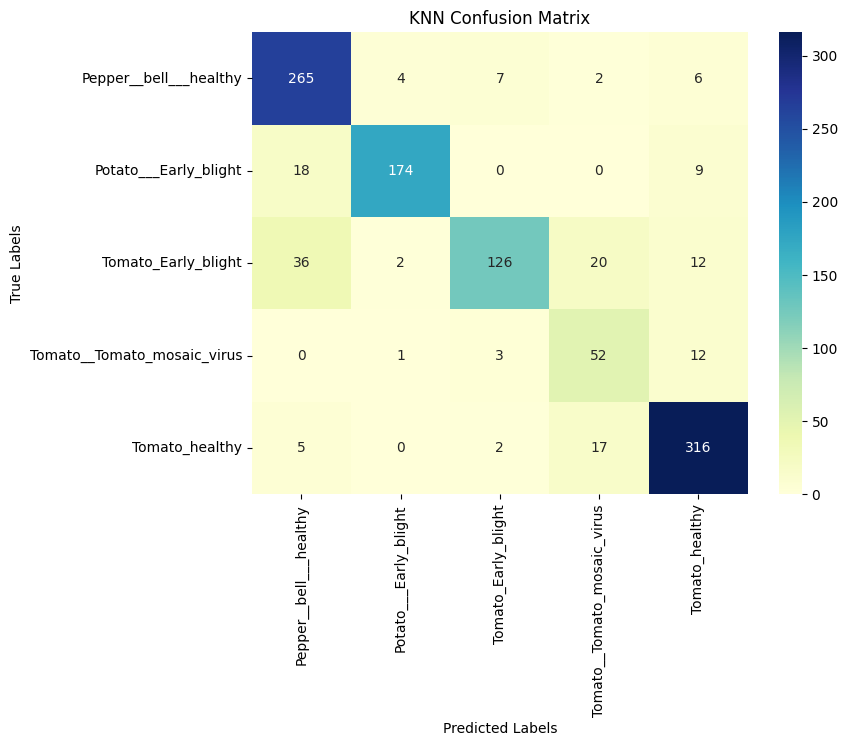

In [21]:
# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='YlGnBu', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cbar=True)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

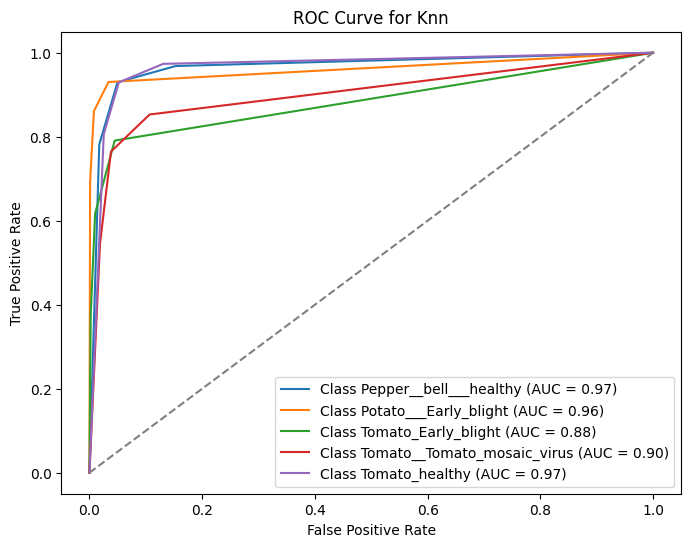

In [22]:
# ROC Curve and AUC
y_test_bin = label_binarize(y_test, classes=np.arange(len(encoder.classes_)))
y_pred_bin = knn_model.predict_proba(X_test)  
# Compute ROC and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Knn')
plt.legend(loc='lower right')
plt.show()

In [33]:
#  Logistic Regression model
log_reg_model = LogisticRegression(max_iter=2000, multi_class='ovr', random_state=42)

# Train the Logistic Regression model
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_logistic = log_reg_model.predict_proba(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {accuracy_log_reg:.4f}')

Logistic Regression Accuracy: 0.8384


In [53]:
print("Precision For Logistic Regression",precision_score(y_test,y_pred_log_reg, average='macro'))

Precision For Logistic Regression 0.837664515375323


In [54]:
print("Recall For Logistic Regression",recall_score(y_test,y_pred_log_reg, average='macro'))

Recall For Logistic Regression 0.8080921004096405


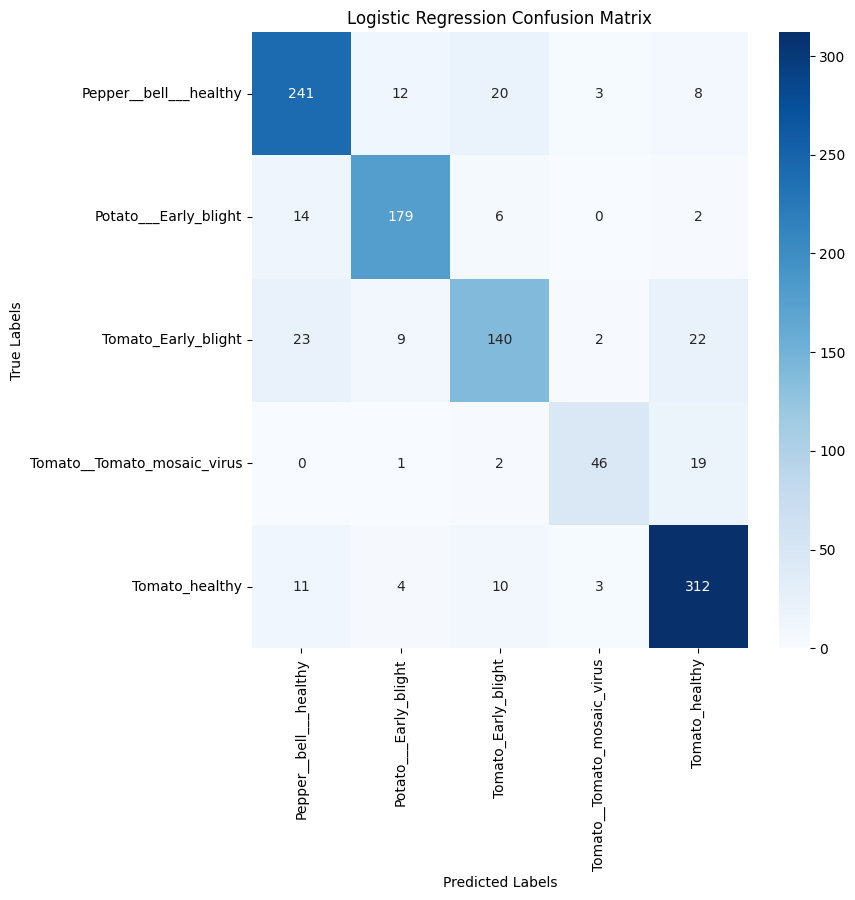

In [104]:
#confusion matrix for logistic
cm = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

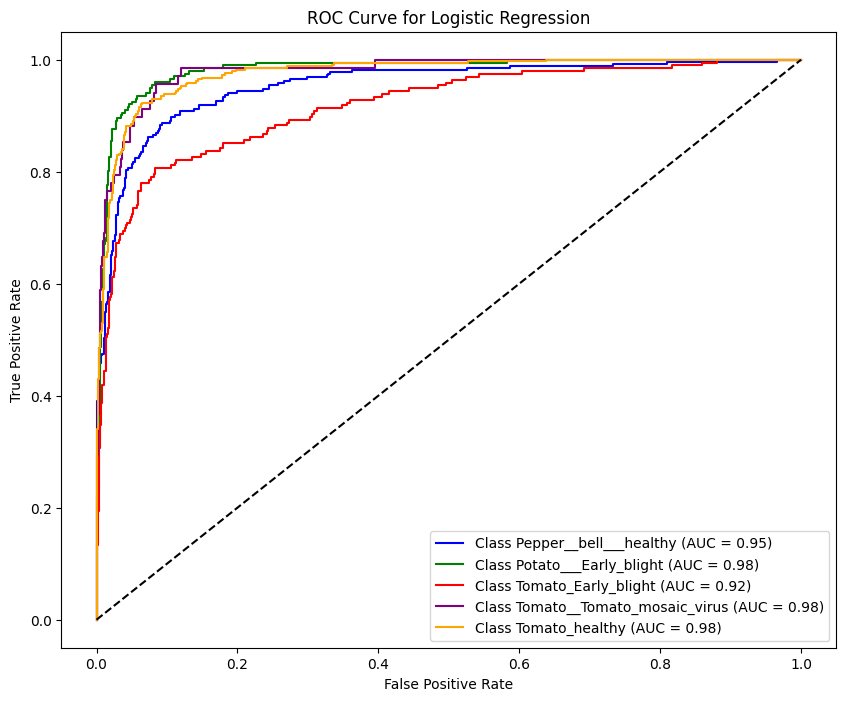

In [105]:
# ROC Curve and AUC
y_test_bin = label_binarize(y_test, classes=np.arange(len(encoder.classes_)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_logistic[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
custom_colors = ['blue', 'green', 'red', 'purple', 'orange']
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})', color=custom_colors[i])
    
plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [36]:
print("loss of KNN:",log_loss(y_test, y_pred_knn_proba))
print("loss of KNN:",(1 - accuracy_score(y_test, y_pred_knn)))

loss of KNN: 2.8633534654991872
loss of KNN: 0.14325068870523416


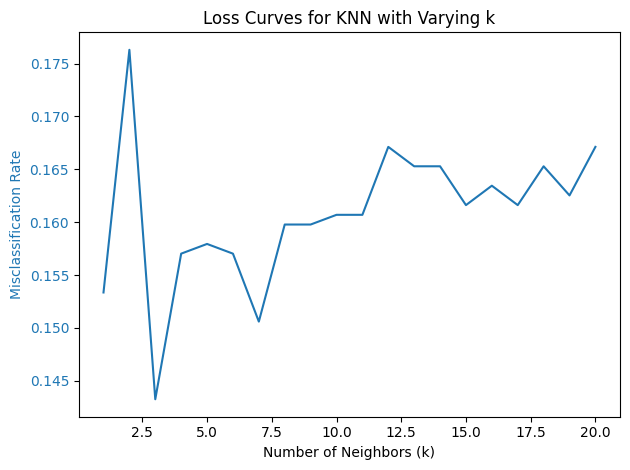

In [40]:
# loss curve of knn (loss)
misclassification_rates = []
log_losses = []
k_values = range(1, 21 )

for k in k_values:
    # Initialize KNN classifier with k neighbors
    model = KNeighborsClassifier(n_neighbors=k)
    # Train the KNN model
    model.fit(X_train, y_train)
    
    # Predict on the training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate misclassification rate (1 - accuracy)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Append the misclassification rate
    misclassification_rates.append(1 - test_accuracy)  # Test misclassification rate
    
    # Predict probabilities and calculate log loss (for multiclass classification)
    y_test_prob = model.predict_proba(X_test)
    try:
        log_loss_value = log_loss(y_test, y_test_prob)
        log_losses.append(log_loss_value)
    except ValueError:
        log_losses.append(np.nan)

# Plotting the loss curves
fig, ax1 = plt.subplots()

# Plot misclassification rates on the left y-axis
ax1.set_xlabel('Number of Neighbors (k)')
ax1.set_ylabel('Misclassification Rate', color='tab:blue')
ax1.plot(k_values, misclassification_rates, color='tab:blue', label='Misclassification Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Title and legend
plt.title('Loss Curves for KNN with Varying k')
fig.tight_layout()
plt.show()

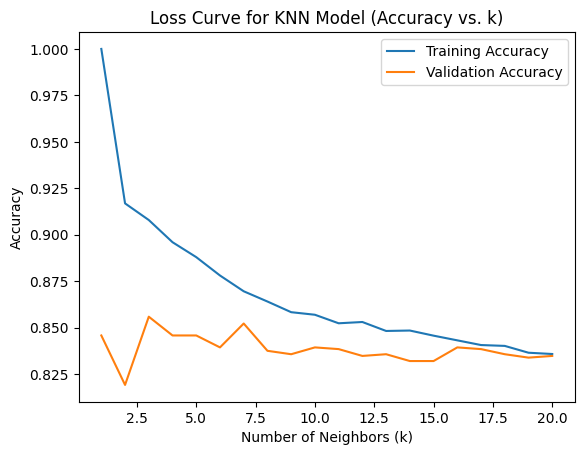

In [106]:
# loss curve of knn (accuracy)
# Range of values for k (number of neighbors)
k_values = range(1, 21)

# Initialize lists to store accuracy results
train_accuracies = []
val_accuracies = []

# Loop over different values of k
for k in k_values:
    # Initialize and train KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # Predict and calculate accuracy on training and validation sets
    train_pred = knn.predict(X_train)
    val_pred = knn.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_test, val_pred)
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Plot the loss curve (accuracy vs. k values)
plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, val_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Loss Curve for KNN Model (Accuracy vs. k)')
plt.legend()
plt.show()

In [45]:
print("log loss of Logistic Regression:",log_loss(y_test, y_proba_logistic))
print("log loss of Logistic Regression:",(1- accuracy_score (y_test, y_pred_log_reg)))

log loss of Logistic Regression: 0.5322898520503058
log loss of Logistic Regression: 0.16161616161616166


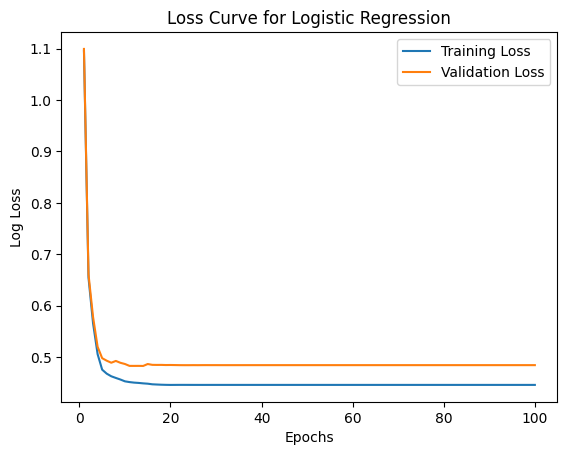

In [89]:

# Initialize lists to store the loss values during training
train_losses = []
val_losses = []
max_ite = range(1, 101)
# Simulate training over epochs
for epoch in max_ite:
    # Create a new LogisticRegression model for each epoch
    model = LogisticRegression(solver='lbfgs', max_iter=epoch)
    model.fit(X_train_scaled, y_train)
    
    # Predict probabilities
    train_prob = model.predict_proba(X_train_scaled)
    val_prob = model.predict_proba(X_test_scaled)
    
    # Calculate log loss (binary cross-entropy)
    train_loss = log_loss(y_train, train_prob)
    val_loss = log_loss(y_test, val_prob)
    
    # Append the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the loss curves
plt.plot(max_ite, train_losses, label='Training Loss')
plt.plot(max_ite, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Loss Curve for Logistic Regression')
plt.legend()
plt.show()

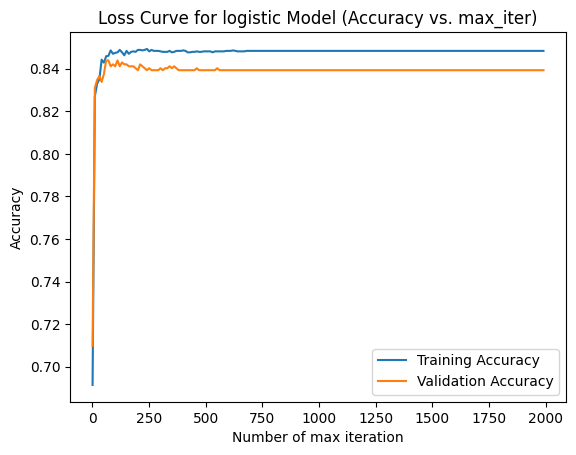

In [43]:
import warnings 

warnings.filterwarnings("ignore" , category=UserWarning)
# loss curve for logistic (accuracy)
# Range of values for max iteration
max_ite = range(1, 2000,10)

# Initialize lists to store accuracy results
train_accuracies = []
val_accuracies = []

# Loop over different values of iteration
for k in max_ite:
    # Initialize and train KNN model
    logistic = LogisticRegression(solver='lbfgs', max_iter=k)
    logistic.fit(X_train, y_train)
    
    # Predict and calculate accuracy on training and validation sets
    train_pred =logistic.predict(X_train)
    val_pred = logistic.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_test, val_pred)
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Plot the loss curve (accuracy vs. max_iter values)
plt.plot(max_ite, train_accuracies, label='Training Accuracy')
plt.plot(max_ite, val_accuracies, label='Validation Accuracy')
plt.xlabel('Number of max iteration')
plt.ylabel('Accuracy')
plt.title('Loss Curve for logistic Model (Accuracy vs. max_iter)')
plt.legend()